In [1]:
import sys
sys.path.append('../../')
sys.path.append('../')

from codes.docs.analysis import data_preprocessing, genetic_file_preprocess
from codes.docs.analysis.nimagen import genes, stats, visualisation

import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
import scipy.io
import glob
from collections import defaultdict
%matplotlib inline

# attempting with different prs thresholds

In [2]:
european_term = pd.read_csv('../../dataset/preprocessed_dataset/imaging_data/log_file/rel3/volumetric/european_volumetric_df_rel3_batch2.csv')

In [3]:
european_term = european_term[~european_term['available_dmri'].isna()]

In [4]:
european_term = european_term.drop_duplicates(subset=['ID'],keep='first')

In [5]:
#to use in FBA we need to transform ID and Session to sub- and ses-
# european_term['ID'] =  'sub-' + european_term['ID']
# european_term['Session'] =  'ses-' + european_term['Session'].astype('str')
european_term['ID/Session'] = 'sub-' + european_term['ID'] +'/'+'ses-' + european_term['Session'].astype('str')

In [6]:
to_exclude=['sub-CC01105XX08/ses-99330','sub-CC00545XX18/ses-170400'] # bad mask

In [7]:
european_term = european_term[~european_term['ID/Session'].isin(to_exclude)]

In [20]:
#we remove outliers related to ancestry
df = european_term.copy()

ancestry = [f'euro_Anc_PC{i}'
            for i in range(1, 4)]  # remove any ancestry outliers

df = stats.MassUnivariate.remove_outliers(
    df,
    col=ancestry,
    threshold=3.5,
    remove_schemes='any',
    percentage_of_outlier=0.1)



#divide into high and low risk in three quarters

In [9]:
PRS_all_scores = genetic_file_preprocess.Cohort.preprocess_PRSice_PRS_Anc_files('../../codes/gene_set/PRSice/output/scz/PRS_100.all_score',column_prefix='new_SCZ_')

In [10]:
df = df.merge(PRS_all_scores,on='ID')

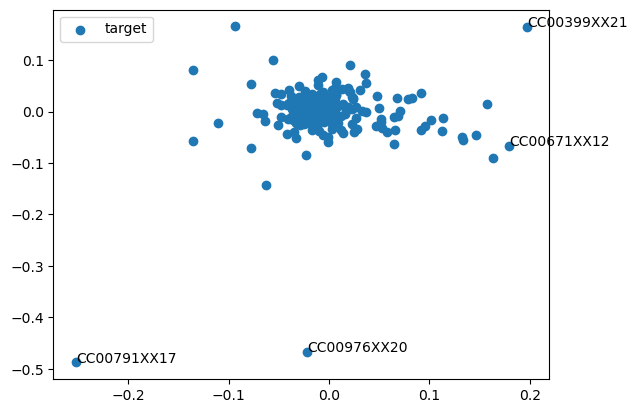

In [11]:
_ , _ = genetic_file_preprocess.Cohort.remove_outliers(
    european_term,
    to_examine=['euro_Anc_PC2', 'euro_Anc_PC3'],
    to_annotate='ID')

In [11]:
SCZ_PRS = [i for i in df.columns if 'new_SCZ' in i]

In [12]:
prs_pca_model,PRS_pca,loading_matrix = stats.FeatureReduction.perform_PCA(df,dependentVar_cols=SCZ_PRS,scaling=True)

In [13]:
df['SCZ_PC1'] = PRS_pca[:,0]

In [14]:
low_risk,high_risk = stats.Stability_tests.divide_high_low_risk(df['SCZ_PC1'],high_perc=.20, low_perc=.20)

In [31]:
df['risk'] = ['low' if i in low_risk else 'high' if i in high_risk else np.nan for i in df.index.values]

In [32]:
new_df = df[~df['risk'].isna()].reset_index(drop=True)

In [39]:
new_df[['ID/Session','sex','PMA','GA','ICV','TBV','risk']+ancestry].to_csv('../../codes/FBA/available_subjects_PRSrisk.txt',index=False,header=None)

In [19]:
df = data_preprocessing.Volumes.Imperial.group_Imperial_volumes(df,grouping=['segmented'],drop_duplicates=True)

In [21]:
euro_term_mass_univariate = stats.MassUnivariate.calculate_mass_univariate_across_multiple_thresholds(df,
                                                                         cat_independentVar_cols=['sex'],
                                                                        thresholds=[i for i in df.columns if 'SCZ' in i],
                                                                         cont_independentVar_cols=['GA','PMA','ICV']+ancestry,
                                                                         dependentVar_cols=[i for i in df.columns if 'Imperial' in i])

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 112/112 [00:14<00:00,  7.65it/s]


In [22]:
data_preprocessing.Volumes.Imperial.get_segment(euro_term_mass_univariate.sort_values('PRS_pval'),col='Connection',tissue=['WM'])

,Connection,const_coef,const_pval,GA_coef,GA_pval,PMA_coef,PMA_pval,ICV_coef,ICV_pval,euro_Anc_PC1_coef,euro_Anc_PC1_pval,euro_Anc_PC2_coef,euro_Anc_PC2_pval,euro_Anc_PC3_coef,euro_Anc_PC3_pval,PRS_coef,PRS_pval,sex_male_coef,sex_male_pval,threshold
5727,Imperial 79,29569.597772,9.080579e-257,-33.383581,0.792578,-1453.574494,4.243465e-13,3848.189922,4.050893e-63,15.216511,0.878735,-87.741309,0.368360,48.031409,0.623692,-240.368968,0.015474,889.110472,0.000026,new_SCZ_Pt_0.042
5422,Imperial 79,29578.200589,1.058351e-256,-33.364518,0.792728,-1460.780665,3.070089e-13,3850.154388,3.552094e-63,14.282516,0.886249,-93.262587,0.337564,49.648801,0.612044,-238.531777,0.016152,871.676445,0.000038,new_SCZ_Pt_0.017
5178,Imperial 79,29574.263046,9.939631e-257,-32.858901,0.795799,-1458.604648,3.405639e-13,3847.673776,4.454324e-63,9.655410,0.923249,-91.457167,0.347518,52.153143,0.594144,-239.259792,0.016287,879.656067,0.000032,new_SCZ_Pt_0.0079
5849,Imperial 79,29568.975500,9.548558e-257,-36.772882,0.772197,-1449.885154,5.165354e-13,3847.820287,4.432787e-63,12.743639,0.898572,-87.452389,0.370248,44.899823,0.646753,-239.087845,0.016426,890.371538,0.000025,new_SCZ_Pt_0.061
5361,Imperial 79,29576.790577,1.073570e-256,-32.360006,0.798856,-1459.706643,3.273788e-13,3849.292757,4.000201e-63,14.566246,0.884029,-96.727427,0.319193,50.513937,0.605894,-236.575006,0.016914,874.533904,0.000036,new_SCZ_Pt_0.014
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2542,Imperial 56,1129.523016,4.032613e-179,10.559209,0.339207,-30.288717,6.400119e-02,111.179510,7.624632e-14,13.761334,0.109625,-5.663980,0.500799,-11.122339,0.191866,-0.019983,0.998085,31.326145,0.083116,new_SCZ_Pt_2.7e-06
6512,Imperial 61,1908.819777,1.530053e-181,-20.232329,0.266653,-13.149380,6.263620e-01,221.874909,1.739729e-18,0.300222,0.983412,-5.408289,0.699263,4.373899,0.755094,-0.029708,0.998341,56.053283,0.059846,new_SCZ_Pt_0.48
5298,Imperial 75,2605.472766,3.180428e-201,-36.581706,0.069753,-10.721584,7.194483e-01,315.582353,4.644688e-27,0.266288,0.986560,8.320258,0.588727,-3.940289,0.799182,-0.031808,0.998376,61.075101,0.063959,new_SCZ_Pt_0.011
1261,Imperial 56,1129.522430,3.944452e-179,10.559007,0.339230,-30.290297,6.426397e-02,111.180626,7.585407e-14,13.762534,0.110137,-5.665087,0.501129,-11.122652,0.191994,-0.007740,0.999260,31.327332,0.083046,new_SCZ_Pt_5.3e-08


In [28]:
stats.matSpDLite(np.corrcoef(data_preprocessing.Volumes.Imperial.get_segment(df,col='column',tissue=['WM']),rowvar=False))

Effective Number of Independent Variables [Veff] is 12.968528270179153
Effective Number of Independent Variables [VeffLi] (Using equation 5 of Li and Ji 2005) is 9.0
The adjusted multiple testing correction p-val is alpha/lower(Meff) = 0.005555555555555556


9.0

In [33]:
data_preprocessing.Volumes.Imperial.get_Imperial_legends()['Imperial 42']

{'name': 'Thalamus right, high intensity part in T2',
 'tissue': None,
 'lobe': None,
 'side': 'right',
 'segment': 'high intensity',
 'structure': 'Thalamus',
 'abbr': 'THAL.right.high intensity'}

<AxesSubplot:xlabel='Adj. Imperial 42', ylabel='Adj. SCZ_PRS_Pt_1e-08'>

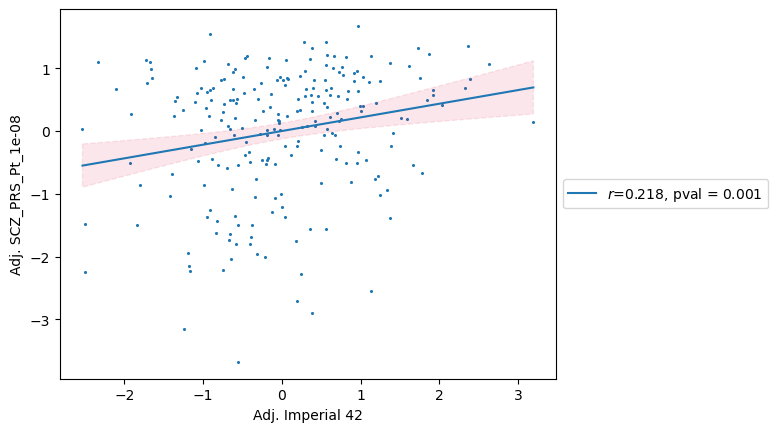

In [30]:
visualisation.SimplePlots.Scatter(x=['Imperial 42'],
                                 y=['SCZ_PRS_Pt_1e-08'],data=european_term,adjust_covar={'x':['ICV','sex','PMA','GA'],
                                                                                        'y':ancestry})

In [31]:
df[['ID/Session','sex','PMA','GA','ICV','TBV','SCZ_PRS_Pt_0.001']+[f'euro_Anc_PC{i}' for i in range(1,4)]].to_csv('../../codes/FBA/available_subjects_PRSPt001.txt',header=None,index=False)

In [30]:
df[df['ID']=='CC01105XX08']

,ID,Session,TBV,ICV,CSF,GM,WM,Background,Ventricles,Cerebellum,...,new_SCZ_Pt_0.23,new_SCZ_Pt_0.27,new_SCZ_Pt_0.33,new_SCZ_Pt_0.39,new_SCZ_Pt_0.48,new_SCZ_Pt_0.57,new_SCZ_Pt_0.69,new_SCZ_Pt_0.83,new_SCZ_Pt_1,SCZ_PRS1


In [15]:

for tract in ['fmi','fma']:
    for fba_measure in ['fd','log_fc','fdc']:
        temp_df = pd.read_csv(f'../../codes/FBA/output/tractography/individual_tracts/{tract}/mean-{fba_measure}-{tract}.txt',
                              header=None,names=[f'{tract}_{fba_measure}_FBA'])
        df = pd.concat([df,temp_df],axis=1)

In [16]:
_, mass_univariate = stats.MassUnivariate.mass_univariate(df,
                                     cat_independentVar_cols=['sex'],
                                    cont_independentVar_cols=['GA','PMA','SCZ_PC1']+ancestry,
                                    dependentVar_cols=[i for i in df.columns if 'FBA' in i],)

In [17]:
mass_univariate.sort_values(by='SCZ_PC1_pval')

,const_coef,const_pval,GA_coef,GA_pval,PMA_coef,PMA_pval,SCZ_PC1_coef,SCZ_PC1_pval,euro_Anc_PC1_coef,euro_Anc_PC1_pval,euro_Anc_PC2_coef,euro_Anc_PC2_pval,euro_Anc_PC3_coef,euro_Anc_PC3_pval,sex_male_coef,sex_male_pval
fma_log_fc_FBA,0.006563,2.347237e-01,-0.020876,0.000050,0.063075,5.117921e-27,0.006178,0.125955,0.006026,0.141113,0.001933,0.632046,0.001560,0.700663,0.057909,3.449253e-12
fmi_log_fc_FBA,-0.014563,3.001094e-02,-0.021970,0.000399,0.055871,7.937442e-17,0.007461,0.126804,0.013553,0.006571,-0.002899,0.553031,0.006380,0.194896,0.061970,4.926832e-10
fma_fdc_FBA,0.275327,1.783510e-207,-0.002535,0.208229,0.021521,1.785772e-21,0.001950,0.224506,-0.000064,0.968431,-0.000320,0.842144,-0.000531,0.742537,0.006062,5.396376e-02
fmi_fdc_FBA,0.256999,7.681406e-195,-0.005663,0.008835,0.031328,8.902063e-34,0.002041,0.233301,0.003339,0.055241,-0.003634,0.034859,0.002267,0.189179,0.005535,9.874930e-02
fmi_fd_FBA,0.261492,5.126118e-208,0.000600,0.752020,0.018009,7.766644e-18,0.000406,0.788331,-0.000344,0.822906,-0.002850,0.061303,0.000531,0.727641,-0.010004,8.394350e-04
fma_fd_FBA,0.276370,4.826824e-231,0.003459,0.028940,0.005112,1.507225e-03,0.000131,0.916877,-0.001995,0.118198,-0.000816,0.516900,-0.000581,0.646106,-0.009110,2.545151e-04


<AxesSubplot:xlabel='Adj. Frontal lobe Right WM', ylabel='Adj. SCZ_PRS1'>

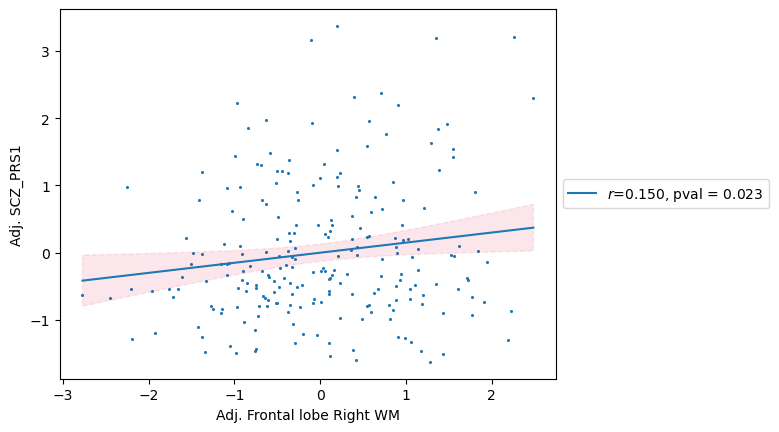

In [35]:
visualisation.SimplePlots.Scatter(x='Imperial 79',
                                 y='SCZ_PRS1',data=df,adjust_covar={'y':ancestry,'x':['ICV','sex','GA','PMA']},xlabel='Frontal lobe Right WM')

In [ ]:
visualisation.SimplePlots.Scatter(x='SCZ_PRS1',
                                 y='SCZ_PRS1',data=df,adjust_covar={'y':ancestry,'x':['ICV','sex','GA','PMA']},xlabel='Frontal lobe Right WM')

In [28]:
sorted(set(['b','c','a']))

['a', 'b', 'c']

In [31]:
european_volumetric_term = pd.read_csv('../../dataset/preprocessed_dataset/imaging_data/log_file/rel3/volumetric/european_volumetric_df_rel3_batch2.csv')

In [33]:
from sklearn.linear_model import LassoCV

In [32]:
european_volumetric_term

,ID,Session,TBV,ICV,CSF,GM,WM,Background,Ventricles,Cerebellum,...,ASD_PRS_Pt_1e-07,ASD_PRS_Pt_1e-06,ASD_PRS_Pt_1e-05,ASD_PRS_Pt_0.0001,ASD_PRS_Pt_0.001,ASD_PRS_Pt_0.01,ASD_PRS_Pt_0.05,ASD_PRS_Pt_0.1,ASD_PRS_Pt_0.5,ASD_PRS_Pt_1
0,CC00749XX24,2600,422755.875,516267.250,89299.500,186431.125,159458.500,42253.500,4211.875,34543.375,...,-0.068172,0.001457,0.014132,-0.003923,-0.003222,-0.002080,-0.001829,-0.001661,-0.001067,-0.000823
1,CC00803XX11,2700,339311.375,426793.875,71507.125,142816.500,137087.375,41193.500,15975.375,24617.375,...,-0.064572,-0.009543,0.008322,-0.005172,-0.002964,-0.002129,-0.001704,-0.001572,-0.001032,-0.000796
2,CC00818XX18,4020,409979.000,495277.375,79400.250,177465.500,163106.125,45333.125,5898.125,30145.000,...,-0.064572,-0.008943,0.003355,-0.008006,-0.003966,-0.002065,-0.001901,-0.001642,-0.001035,-0.000806
3,CC00815XX15,4120,379317.875,454117.125,71501.750,160427.250,156481.750,45103.750,3297.500,25969.125,...,-0.068172,-0.006516,0.009228,-0.006991,-0.002948,-0.002005,-0.001714,-0.001585,-0.001056,-0.000812
4,CC00766XX16,4200,358265.000,441757.625,79461.375,157570.500,137294.250,41553.750,4031.250,27287.250,...,-0.064572,-0.000971,0.005120,-0.006163,-0.003076,-0.002360,-0.001868,-0.001740,-0.001086,-0.000833
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
288,CC00685XX18,226100,425322.625,535228.625,101917.500,190254.125,163305.750,44798.375,7988.500,30173.250,...,-0.088497,-0.006987,0.000992,-0.009806,-0.004350,-0.002211,-0.001744,-0.001626,-0.001078,-0.000831
289,CC00713XX12,229000,434705.625,550515.125,107302.625,183386.125,176498.625,49443.375,8506.875,31518.125,...,-0.088497,-0.003287,0.007648,-0.006845,-0.002441,-0.001915,-0.001654,-0.001570,-0.001054,-0.000817
290,CC00740XX15,238400,406146.000,506014.125,92708.375,172988.125,161010.125,47751.000,7159.750,30949.750,...,-0.047848,-0.002338,0.005636,-0.006541,-0.002602,-0.001650,-0.001549,-0.001526,-0.001029,-0.000791
291,CC00777XX19,239102,419587.375,503957.375,79029.875,174203.500,173343.875,45315.125,5340.125,29430.625,...,-0.044248,0.003317,0.013454,-0.003949,-0.002660,-0.002106,-0.001630,-0.001541,-0.001042,-0.000804


In [34]:
PRS_all_scores = genetic_file_preprocess.Cohort.preprocess_PRSice_PRS_Anc_files('../../codes/gene_set/PRSice/output/scz/PRS_100.all_score',column_prefix='new_SCZ_')

In [38]:
european_volumetric_term = european_volumetric_term.merge(PRS_all_scores,on=['ID'])

In [39]:
SCZ_PRS = [i for i in df.columns if 'new_SCZ' in i]

In [40]:
prs_pca_model,PRS_pca,loading_matrix = stats.FeatureReduction.perform_PCA(european_volumetric_term,dependentVar_cols=SCZ_PRS,scaling=True)

In [9]:
candidate_genes = {'1:98502934_G': 'mir137_rs1625579_G',
 '1:231954101_T': 'DISC1_rs6675281_T',
 '2:185778428_C': 'ZNF804A_rs1344706_C',
 '8:31495581_T': 'NRG1_rs6994992_T',
 '10:61839831_T': 'ANK3_rs9804190_T',
 '10:62179812_T': 'ANK3_rs10994336_T',
 '11:27679916_T': 'BDNF_rs6265_T'}

In [21]:
available_snps_genotyped = genetic_file_preprocess.Cohort.preprocess_PRSice_PRS_Anc_files('../../dataset/genetic_dataset/target_files/genotyped.raw')

In [22]:
available_snps_genotyped.columns = [candidate_genes[i] if i in candidate_genes else i for i in available_snps_genotyped.columns]

In [23]:
df = pd.merge(df,available_snps_genotyped,on='ID',how='left')

In [24]:
df['ANK3_rs10994336_T'] = ['CC' if i == 0 else 'Tcarrier' for i in df['ANK3_rs10994336_T']]

In [68]:
df['ANK3_rs10994336_T'].value_counts()

CC    200
CT     27
TT      2
Name: ANK3_rs10994336_T, dtype: int64

In [76]:
df['mir137'] = ['TT' if i == 0 else 'Gcarrier' for i in df['mir137_rs1625579_G']]

In [25]:
df[['ID/Session','sex','PMA','GA','ICV','TBV','ANK3_rs10994336_T']+[f'euro_Anc_PC{i}' for i in range(1,4)]].to_csv('../../codes/FBA/available_subjects_ANK3.txt',header=None,index=False)

In [84]:
_, mass_univariate = stats.MassUnivariate.mass_univariate(df,
                                     cat_independentVar_cols=['sex','mir137'],
                                    cont_independentVar_cols=['GA','PMA','ICV']+ancestry,
                                    dependentVar_cols=[i for i in df.columns if 'Imperial' in i],)

In [85]:
mass_univariate.sort_values('mir137_TT_pval')

,const_coef,const_pval,GA_coef,GA_pval,PMA_coef,PMA_pval,ICV_coef,ICV_pval,euro_Anc_PC1_coef,euro_Anc_PC1_pval,euro_Anc_PC2_coef,euro_Anc_PC2_pval,euro_Anc_PC3_coef,euro_Anc_PC3_pval,sex_male_coef,sex_male_pval,mir137_TT_coef,mir137_TT_pval
Imperial 25,851.088312,6.825957e-155,-7.165168,0.380956,9.810895,0.414307,99.832903,1.067438e-18,0.855907,0.892349,3.760197,0.543886,-4.640901,0.460497,-29.571614,2.729831e-02,-33.756526,0.007746
Imperial 16,808.371357,1.158774e-134,1.201766,0.901398,44.224702,0.002148,93.628141,6.217576e-13,10.799683,0.151249,0.327936,0.964419,10.964403,0.142607,17.469239,2.700290e-01,-36.594924,0.014887
Imperial 64,2701.303309,9.777877e-168,1.912173,0.932453,-106.146184,0.001551,338.584203,1.615948e-25,17.160229,0.326261,-13.246386,0.438807,6.171372,0.722119,62.291066,9.143822e-02,77.621494,0.026199
Imperial 10,1054.226631,7.470425e-171,-16.694211,0.050883,6.618236,0.596958,112.804133,3.581559e-21,-2.710414,0.680881,-4.414750,0.494053,-4.574161,0.485040,10.155571,4.646881e-01,-28.891504,0.028290
Imperial 12,2960.528302,3.126059e-172,-12.561182,0.593963,149.329648,0.000024,354.750497,1.193149e-25,-3.321249,0.855453,-28.691918,0.109039,5.556169,0.759098,79.830596,3.860395e-02,77.842861,0.032651
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Imperial 83,78925.538823,9.188736e-155,1085.533619,0.153503,-3148.442156,0.005142,14526.416194,4.641618e-36,-593.317873,0.312950,45.046739,0.937566,241.116542,0.679552,-6423.719515,4.600769e-07,-111.321039,0.924051
Imperial 75,1291.001952,9.393640e-148,-39.183843,0.003780,14.421616,0.464329,159.008646,7.201777e-18,2.373296,0.819037,7.284606,0.473507,-2.484276,0.809551,16.500922,4.504788e-01,-1.920750,0.925798
Imperial 77,1316.698743,2.255720e-157,2.762246,0.822379,-25.008489,0.167601,156.307517,7.461279e-20,-2.257907,0.812596,0.930249,0.920537,-1.498069,0.874218,44.369004,2.785194e-02,-1.686739,0.929016
Imperial 73,1364.683267,2.525724e-134,-43.246010,0.009037,-19.196804,0.427150,160.216548,3.916463e-13,-19.511934,0.126112,-0.239535,0.984659,10.756607,0.395222,36.156738,1.782145e-01,1.657002,0.947769


In [86]:
data_preprocessing.Volumes.Imperial.get_Imperial_legends()['Imperial 25']

{'name': 'Gyri parahippocampalis et ambiens posterior part left GM',
 'tissue': 'GM',
 'lobe': None,
 'side': 'left',
 'segment': 'posterior',
 'structure': 'Gyri parahippocampalis et ambiens',
 'abbr': 'GPEA.GM.left.posterior'}

# using enriched pathways

there are 24 gene ontologies enriched in the last GWAS studies. Ranging from ion channel complex, syanpse, cation channel complex, to neuronal cell body.

The implicated genes were downloaded from amigo database.

In [19]:
all_amigo_pathways = defaultdict(list)

In [31]:
with open('../../codes/gene_set/PRSice/SCZ_enriched_pathways_AMIGO.gmt','r') as f:
    pathways=f.readlines()
    
    for pathway in pathways:
        pathway=pathway.replace('\n','').split('\t')
        all_amigo_pathways[pathway[0]]=pathway[2:]

In [32]:
{k:len(v) for k,v in all_amigo_pathways.items()}

{'GO_dendrite': 621,
 '': 0,
 'GO_transmembrane_transporter_complex': 394,
 'GO_ion_gated_channel_activity': 354,
 'GO_somatodendritic_compartment': 841,
 'GO_neuronal_cell_body': 489,
 'GO_voltage_gated_ion_channel_activity': 204,
 'GO_voltage_gated_channel_activity': 205,
 'GO_modulation_of_chemical_synaptic_transmission': 550,
 'GO_dendritic_tree': 623,
 'GO_regulation_of_cellular_localization': 989,
 'GO_postsynapse': 662,
 'GO_neuron_projection': 1323,
 'GO_synapse': 1468,
 'GO_axon': 648,
 'GO_regulation_of_neuron_differentiation': 250,
 'GO_transporter_complex': 421,
 'GO_ion_channel_complex': 300,
 'GO_gated_channel_activity': 356,
 'GO_cation_channel_complex': 193,
 'GO_regulation_of_trans_synaptic_signaling': 551,
 'GO_nervous_system_development': 2213,
 'GO_voltage_gated_cation_channel_activity': 157,
 'GO_voltage_gated_calcium_channel': 53,
 'GO_regulation_of_cation_channel_activity': 126}